# BigEarthNetv2-RGB data preparation
The BigEarthNetv2 dataset contains 549488 Sentinel-2 image patches with the corresponding mask that can be used to train a model for satellite image classification and segmentation. For each patch the dataset contains 12 of the 13 bands, that is, all but B10. More information about the dataset is available at the [BigEarthNet](https://bigearth.net/) website.

* B01 (resolution = 60m/px, central wavelength = 443nm, bandwidth = 20nm, use: aerosol detection)
* B02 (blue, resolution = 10m/px, central wavelength = 490nm, bandwidth = 65nm, use: Band 2 is useful for soil and vegetation discrimination, forest type mapping and identifying man-made features. It is scattered by the atmosphere, it illuminates material in shadows better than longer wavelengths, and it penetrates clear water better than other colors. It is absorbed by chlorophyll, which results in darker plants.)
* B03 (green, resolution = 10m/px, central wavelength = 560nm, bandwidth = 35nm, use: it gives excellent contrast between clear and turbid (muddy) water, and penetrates clear water fairly well. It helps in highlighting oil on water surfaces, and vegetation. It reflects green light stronger than any other visible color. Man-made features are still visible)
* B04 (red, resolution = 10m/px, central wavelength = 665nm, bandwidth = 30nm, use: it is strongly reflected by dead foliage and is useful for identifying vegetation types, soils and urban (city and town) areas. It has limited water penetration and doesn’t reflect well from live foliage with chlorophyll.)
* B05 (red edge, resolution = 20m/px, central wavelength = 705nm, bandwidth = 15nm, use: vegetation classification)
* B06 (resolution = 20m/px, central wavelength = 740nm, bandwidth = 15nm, use: vegetation classification)
* B07 (resolution = 20m/px, central wavelength = 783nm, bandwidth = 20nm, use: vegetation classification)
* B08 (NIR, resolution = 10m/px, central wavelength = 842nm, bandwidth = 115nm, use: The near infrared band is good for mapping shorelines and biomass content, as well as at detecting and analyzing vegetation)
* B8A (resolution = 20m/px, central wavelength = 865nm, bandwidth = 20nm, use: For classifying vegetation)
* B09 (resolution = 60m/px, central wavelength = 945nm, bandwidth = 20nm, use: it is good for detecting water vapour)
* B10 (resolution = 60m/px, central wavelength = 1375nm, bandwidth = 30nm, use: For cirrus cloud detection)
* B11 (SWIR 1, resolution = 20m/px, central wavelength = 1610nm, bandwidth = 90nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)
* B12 (SWIR 2, resolution = 20m/px, central wavelength = 2190nm, bandwidth = 180nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)

## Remote sensing derived indices 
RGB, NIR and SWIR bands can be used to build indices to enhance the response for specif types of land cover such as vegetation built or burnt areas. Some of these indeces are: NDVI, SAVI, ARVI, VARI, NDBI, NBR.

## Data download and decompression
We will use only the three RGB bands: B02 (blue), B03 (green), and B04 (red). The masks have been created using 19 classes of the CORINE Land Cover (CLC) nomenclature. The data preparation phase consists of 

1. Collect the RGB bands of each image patch
2. Create a PNG file for each patch using the three RGB bands in the TIFF files
3. Create three datasets for training, validation and test

The Sentinel-2 BigEarthNetv2 dataset can be downloaded as a single compressed file of 59 GB. It can be decompressed, in a MS Windows OS,
using [7-Zip](https://www.7-zip.org/)  

## Structure of the dataset
The BigEarthNetv2 dataset is organized into two root folders, one for the images and one for the masks, like in the following example with only two image patches of one tile. 
* BigEarthNet-S2
    * images
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B04.tif
    * masks
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif

Each patch folders contain 12 TIFF images, one for each Sentinel-2 bands. A patch mask folder contain only one TIFF file. The file name is built using the convention 

&lt;satellite&gt;&lt;sensor&gt;&lt;date&gt;&lt;N9999&gt;&lt;tile-code1&gt;&lt;tile-code2&gt;&lt;patch-code1&gt;&lt;patch-code2&gt;&lt;band&gt;

In [32]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import matplotlib
import matplotlib.pyplot as plt
import rasterio
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Matplotlib version: %s"%matplotlib.__version__)
print("rasterio version: %s"%rasterio.__version__)

NumPy version: 1.26.4
Matplotlib version: 3.8.4
rasterio version: 1.4.3


We import some functions and constants developed for the project

In [2]:
#from scripts.bigearthnetv2_data_preparation import *

In development phase we have to execute the script to use the updated functions without restarting the notebook

In [3]:
%run -i lib/bigearthnetv2_lib.py

## Data collection
We select three bands for each 

In [4]:
BIGEARTHNETv2_DIR = 'data/BigEarthNet-S2'
IMAGES_DATA_DIR = pathlib.Path(BIGEARTHNETv2_DIR + '/images')
MASKS_DATA_DIR = pathlib.Path(BIGEARTHNETv2_DIR + '/masks')

In [5]:
band_file = 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B01.tif'

In [6]:
def read_band_name(band_name):
    '''
    Returns the information encoded in the band file name:
    tile, patch, band, and date of acquisition.
    '''
    band = band_name[-7:-4]
    patch = band_name[-13:-8]
    tile = band_name[-25:-14]
    date = band_name[-47:-39]
    return tile, patch, band, date

In [7]:
tile, patch, band, date = read_band_name(band_file)
print('Tile: {}\nPatch: {}\nBand: {}\nDate: {}'.format(tile, patch, band, date))

Tile: R022_T33UUP
Patch: 26_57
Band: B01
Date: 20170613


In [8]:
def create_png_file_name(tile, patch, date):
    return tile + '_' + patch + '_' + date + '.png'

In [9]:
create_png_file_name(tile, patch, date)

'R022_T33UUP_26_57_20170613.png'

In [10]:
def list_data_files(root_path, start_tile_index, max_num_tiles):
    '''
    This function creates a list of tiles each containing
    lists of patches with three RGB bands each or a mask.
    The 2nd argument is the index of the first tile to be included. 
    The 3rd argument is the number of tiles to be returned. 
    '''
    tiles_list = []
    tiles_paths = [pathlib.Path(x) for x in root_path.iterdir() if x.is_dir()]
    for tile_path in tiles_paths[start_tile_index:max_num_tiles]:
        # print(tile_path.name)
        patches_list = []
        for patches_path in tile_path.iterdir():
            bands_list = []
            for band_path in patches_path.iterdir():
                band_type = band_path.name[-7:]
                if (band_type == 'B02.tif' or band_type == 'B03.tif' or band_type == 'B04.tif' or band_type == 'map.tif'):
                    bands_list.append(band_path)
            patches_list.append(bands_list)
        tiles_list.append(patches_list)
    return tiles_list

In [11]:
def print_raster_list(tiles_list): 
    '''
    Prints the content of the nested folders
    within the list passed as argument.
    tiles[patches[bands[]]]
    '''
    for patches_list in tiles_list:
        for bands_list in patches_list:
            for band in reversed(bands_list):
                print(band.name)
            print('\n')
        print('\n')

In [14]:
tiles_list = list_data_files(IMAGES_DATA_DIR, 1, 2)

In [15]:
print_raster_list(tiles_list)

S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_B02.tif


S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_B02.tif






In [16]:
tiles_mask_list = list_data_files(MASKS_DATA_DIR, 1, 2)
len(tiles_mask_list)

1

In [17]:
print_raster_list(tiles_mask_list)

S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_reference_map.tif


S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_reference_map.tif






## Creating a raster PNG RGB dataset
A PNG file doesn't contain metadata so, in order to create a RGB image, we only need to use the bands from three GeoTIFF file. We also need to change the scale of the pixel values from 16 bits to 8 bits (256 values).

In [18]:
def normalize(data_array):
    '''
    This function transforms the bit depth of the TIFF bands from 16 to 8 (0-255) for the PNG files.
    '''
    return (data_array - np.min(data_array)) * ((255 - 0) / (np.max(data_array) - np.min(data_array))) + 0

In [19]:
def createPNG(source_path_list, target_path):
    '''
    This function creates a multiband PNG file from a list of GeoTIFF files 
    containing one band each. For an RGB file the source list shall contain three bands
    in the RGB order. For Sentinel-2 it is B04, B03, B02. If the target file already exists
    it doesn't create a new one and will return 1, otherwise it will create a new raster
    and will return 0 
    '''
    SUCCESS = 0
    FAILURE = 1
    if (os.path.isfile(target_path)):
        return FAILURE 
        
    band_list = []
    dataset = rasterio.open(source_path_list[0])
    width = dataset.width
    height = dataset.height
    count = len(source_path_list)

    for raster_path in source_path_list:
        dataset = rasterio.open(raster_path)
        band = normalize(dataset.read(1))
        band_list.append(band)
        
        
    with rasterio.open(target_path,
                    mode='w',
                    driver='PNG',
                    height=height,
                    width=width,
                    count=count,
                    dtype='uint8') as target_dataset:
        band_index = 1
        for band in band_list:
            target_dataset.write(band, band_index)
            band_index += 1
    return SUCCESS

In [20]:
createPNG(tiles_list[0][0], 'data/rgb.png')

1

In [21]:
get_raster_attributes('data/rgb.png')

dtypes: uint8
Number of bands: 3
Band width: 120, band height: 120
Dataset affine transform:
 | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
EPSG Coordinates Reference System: None
Bounding box 
 left: 0.00, 
 bottom: 120.00, 
 right: 120.00, 
 top: 0.00


(120,
 120,
 None,
 Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0))

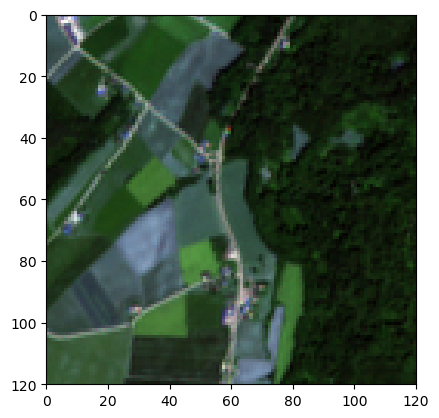

In [22]:
from rasterio.plot import show
src = rasterio.open('data/rgb.png')
show(src)
src.close()

In [23]:
num_tiles = len(tiles_list)
print('Number of tiles: {:d}'.format(num_tiles))

Number of tiles: 1


In [24]:
def createPNGs(tiles_list):
    '''
    This function creates a PNG for each patch of the tiles
    in the list. The path of the PNG files is added to a list 
    that will be returned. In case a PNG file already exist it 
    only adds its path to the list.
    '''
    png_patches = []
    for patches_list in tiles_list:
        for bands_list in patches_list: 
            band_name = bands_list[0].name
            #print('Band name: {}'.format(band_name))
            tile, patch, band, date = read_band_name(band_name)
            patch_dir = bands_list[0].parent
            png_file_name = str(patch_dir) +  '/' + create_png_file_name(tile, patch, date)
            if (createPNG(bands_list, png_file_name) == 1):
                print('The PNG file already exists.')
                png_patches.append(png_file_name)
            else:
                png_patches.append(png_file_name)
    return png_patches

In [30]:
pngs_list = createPNGs(tiles_list)

The PNG file already exists.
The PNG file already exists.


In [31]:
pngs_list

['data\\BigEarthNet-S2\\images\\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER\\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45/R022_T34VER_00_45_20170613.png',
 'data\\BigEarthNet-S2\\images\\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER\\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46/R022_T34VER_00_46_20170613.png']

In [26]:
masks = []
for patches_list in tiles_mask_list:
    for masks_list in patches_list:
        for mask in masks_list: 
            masks.append(masks_list[0])

In [27]:
for mask in masks:
    print(mask)

data\BigEarthNet-S2\masks\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_reference_map.tif
data\BigEarthNet-S2\masks\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_reference_map.tif


## Zip and unzip PNG files

In [34]:
compressed_pngs_path = 'data/bigearthnet_pngs.zip'
with ZipFile(compressed_pngs_path, 'w') as zipObj:
    for png in pngs_list:
        zipObj.write(png)

In [36]:
unzip_folder = 'zip/'
with ZipFile(compressed_pngs_path, 'r') as zipObj:
        zipObj.extractall(path=f'{unzip_folder}')

## Visualization

In [28]:
from skimage import io
from skimage import exposure
from skimage.io import imread

def plot_examples(tiles_list, masks_list):
    fig_rows = len(masks_list)
    fig, axs = plt.subplots(nrows=fig_rows, ncols=2, figsize=(5, 3), layout='constrained')
    for row in range(0, fig_rows):
        img = imread(tiles_list[row])
        msk = imread(masks_list[row])
        img_equalized = exposure.equalize_hist(img)
        msk_equalized = exposure.equalize_hist(msk)
        axs[row, 0].set_axis_off()
        axs[row, 1].set_axis_off()
        axs[row, 0].imshow(img_equalized)
        axs[row, 1].imshow(msk_equalized)

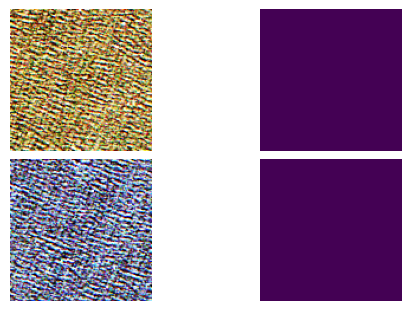

In [29]:
plot_examples(pngs_list, masks)